In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

import pandas as pd

import random
import numpy as np
import matplotlib.pyplot as plt

## Data

In [2]:
class Dataset(Dataset):
    def __init__(self, features_file, label_file):
        features = pd.read_csv(features_file)
        labels = pd.read_csv(label_file)
        
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        tensor_features = torch.tensor(self.features.iloc[idx].values, dtype=torch.float)
        tensor_labels = torch.tensor(self.labels.iloc[idx].values, dtype=torch.float)

        return tensor_features, tensor_labels

In [3]:
dataset = Dataset('H1_AI_Dataset/H1_Features_Wh.csv', 'H1_AI_Dataset/H1_Labels_Wh.csv')
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

## MLP

In [13]:
class MLP(nn.Module):
    def __init__(self, input_size=8, output_size=6):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.ln1 = nn.LayerNorm(256)

        
        self.fc2 = nn.Linear(256, 128)
        self.ln2 = nn.LayerNorm(128)

        self.fc3 = nn.Linear(128, 64)
        self.ln3 = nn.LayerNorm(64)

        self.fc4 = nn.Linear(64, 32)
        self.ln4 = nn.LayerNorm(32)

        
        self.fc5 = nn.Linear(32, 6)


        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='leaky_relu')
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='leaky_relu')
        nn.init.kaiming_normal_(self.fc3.weight)  

    def forward(self, x):
        x = self.fc1(x)
        x = F.leaky_relu(self.ln1(x), negative_slope=0.05)

        
        x = self.fc2(x)
        x = F.leaky_relu(self.ln2(x), negative_slope=0.05)

        x = self.fc3(x)
        x = F.leaky_relu(self.ln3(x), negative_slope=0.05)

        x = self.fc4(x)
        x = F.leaky_relu(self.ln4(x), negative_slope=0.05)

        
        x = self.fc5(x)
        return x

In [14]:
# Instantiate the model, optimizer, and loss function
model = MLP()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.SmoothL1Loss()

In [15]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

MLP(
  (fc1): Linear(in_features=8, out_features=256, bias=True)
  (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (ln3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (ln4): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (fc5): Linear(in_features=32, out_features=6, bias=True)
)

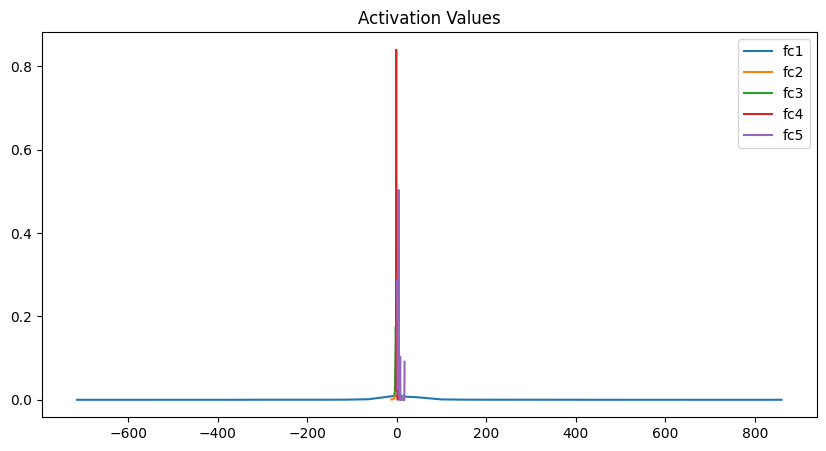

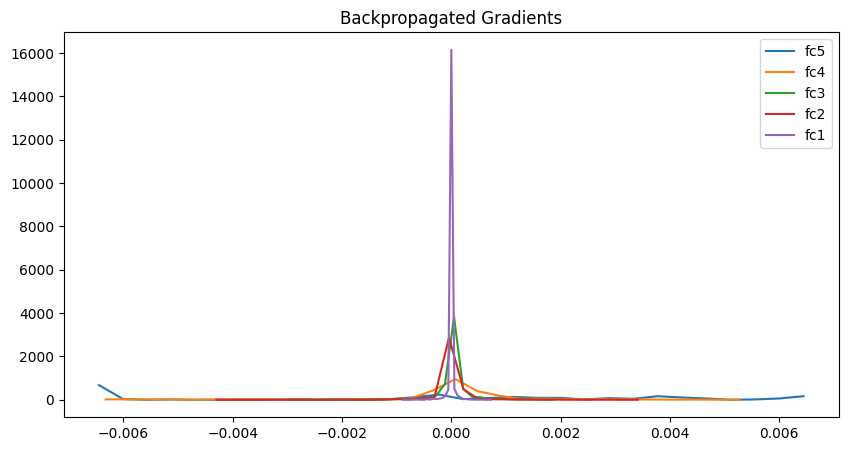

In [16]:
activations = {}
gradients = {}

# Define hook functions
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

def get_gradient(name):
    def hook(model, input_grad, output_grad):
        gradients[name] = output_grad[0].detach()
    return hook

# Register hooks for each layer of interest
for name, layer in model.named_modules():
    if isinstance(layer, torch.nn.Linear):  # Assuming you're interested in linear layers
        layer.register_forward_hook(get_activation(name))
        layer.register_backward_hook(get_gradient(name))


model.train()
total_loss = 0
for batch_idx, (data, targets) in enumerate(dataloader):
    data, targets = data.to(device), targets.to(device)

    # Forward pass
    outputs = model(data)
    loss = loss_function(outputs, targets)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

    # You may want to collect activations and gradients statistics periodically
    # For example, after a certain number of batches or at the end of an epoch


# After collecting the data, plot the variance plots
# You can use np.histogram and plt.plot to create density plots similar to your images

def plot_variance(data_dict, title):
    plt.figure(figsize=(10, 5))
    for name, data in data_dict.items():
        # Flatten the tensor to 1D
        data = data.view(-1).cpu().numpy()
        # Compute the density
        density, bins = np.histogram(data, bins=30, density=True)
        # Compute the bin centers
        bin_centers = 0.5 * (bins[1:] + bins[:-1])
        # Plot the density
        plt.plot(bin_centers, density, label=name)
    plt.title(title)
    plt.legend()
    plt.show()

# Plot the activations and gradients
plot_variance(activations, 'Activation Values')
plot_variance(gradients, 'Backpropagated Gradients')